# Talk to your data with RAG and Llama 3.2

In this notebook, you will learn how to use RAG and Llama 3.2 to talk to your data. Llama 3.2 is chosen because of its smaller size and faster speed compared to the original Llama. This allows us to run the code locally. RAG allows the model to generate text that is factually accurate and coherent.

## Getting Started

First, we need to install the necessary libraries. If you're using conda, you can import the environment from the `environment.yml` file included in this repository.

```bash
conda env create -f environment.yml
conda activate llama-rag
```

### Ollama

We will use the `ollama` library to interact with the Llama 3.2 model offline. You can download it from [https://ollama.com](https://ollama.com).
Once installed, you can download and run the Llama 3.2-3b model using the following command:

```bash
ollama run llama3.2
```

You can verify your environment by running the cell below.

In [1]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.llms import Ollama

## Setting up the vector database

RAG requires that we have some way of storing the embeddings of our external information. This requires a database that can store and retrieve the embeddings. It also means that we need some way of embedding the data. We will use `Chroma` as the vector store and `HuggingFace` to load a pre-trained embedding model.

## Splitting the input

Large Language Models are not inherently good at utilizing long contexts ([Liu et al.](https://arxiv.org/abs/2307.03172)). To overcome this limitation, we need to embed smaller parts of the input before storing them in Chroma. You should play around with the chunk size and overlap parameters to see how they affect the performance of the model.

In [ ]:
# Load the paper
loader = PyMuPDFLoader("2410.05258v1.pdf")
documents = loader.load()

# Split the documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(documents)

# Create embeddings
embeddings = HuggingFaceEmbeddings()

# Create a vector store
db = Chroma.from_documents(texts, embeddings)

# Naive RAG

Now that we have our vector store, we can load Llama 3.2 and test out our naive RAG model. We need the following components:
1. A **retriever** to fetch documents from our vector store.
2. A **generator**, or LLM, to generate the answer.
3. A **prompt** to guide the generation process.

The retrieve can be created from our database using `as_retriever()`. As stated above, we will use Llama 3.2 as our generator. This can be loaded using Ollama. Finally, we will set up a prompt that will inject the context and question into a template that will guide the generation. This is implemented using LangChain.

In [3]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

retriever = db.as_retriever()

llm = Ollama(model="llama3.2")

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to augment your own knowledge."),
    ("human", "Context: {context}"),
    ("human", "Question: {input}"),
    ("human", "Please provide a detailed answer, combining information from the context (if relevant) and your own knowledge.")
])

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
def ask_question(chain, question):
    result = chain.invoke({"input": question})
    print("Question:", question)
    print("\n ** WITH CONTEXT **\n")
    print("Answer:", result['answer'])
    print("\nSources:")
    for doc in result['context']:
        print(doc.metadata)
    print("\n")

    default_result = llm.invoke(question)
    print("\n** WITHOUT CONTEXT **\n")
    print(default_result)

question = "How does the differential transformer differ from a traditional transformer?"
ask_question(rag_chain, question)

## Evaluating the Results

We can immediately see that the context provided from our vector store helped produce an answer that was relevant to Transformers - the machine learning architecture. Without this context, the model generated a response related to Transformers - the electrical device. However, we can see that the answer is not perfect. We would expect to a main point of the paper: the cancellation of noise leading to sparse attention patterns.

## Advanced RAG

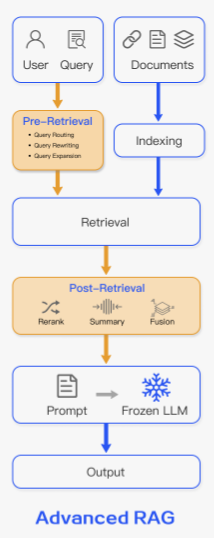

To improve the responses of our model, we must move away from naive RAG and implement advanced RAG techniques. Advanced RAG techniques augment the traditional pipeline by adding pre- and post-retrieval steps. These steps can include:
1. enhancing data granularity - splitting the input into smaller chunks
2. using multiple queries to retrieve more relevant documents
3. using a more advanced retriever to retrieve more relevant documents
4. adding metadata to the retrieval process

Post-retrieval steps primarily focus on re-ranking the retrieved documents to ensure that the most relevant documents are used in the generation process.

## Multi-Query

The idea behind multi-query is to use multiple queries to retrieve more relevant documents. This can be done by using different queries that are related to the input. For example, if the input is a question about the capital of France, we can use queries like "What is the capital of France?" and "Where is the Eiffel Tower located?" to retrieve more relevant documents.

In [5]:
# Multi Query
template = """Your task is to generate five different versions of the given user question to retrieve relevant documents from a vector database.
Using the different perspectives from the retrieved documents, you should generate a response to the user question. Original question: {question}"""
prompt_multi_query = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain.load import dumps, loads

generate_queries = (
    prompt_multi_query
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
retrieval_chain = generate_queries | retriever.map() | get_unique_union

In [ ]:
from operator import itemgetter

# RAG
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to augment your own knowledge.

Context: {context}

Question: {question}

Please provide a detailed answer, combining information from the context (if relevant) and your own knowledge.
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

result = final_rag_chain.invoke({"question": question})
print(result)


Perhaps the result is a little better, but it still doesn't address the main point of the paper. The next strategy we will try is called RAG-Fusion

# RAG-Fusion

Generating multiple queries did not seem to enhance the quality of the model's reponses in this case. In this last strategy, we will first generate multiple queries and retrieve documents for each query. The results will then be reranked based on the relevance of the documents to the input. This will ensure that the most relevant documents are used in the generation process. This relies on a technique called Reciprocal Rank Fusion ([Cormack et al.](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf)).

In [7]:
# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [8]:
generate_queries = (
    prompt_rag_fusion 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [ ]:
def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

In [ ]:
# RAG
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to augment your own knowledge.

Context: {context}

Question: {question}

Please provide a detailed answer, combining information from the context (if relevant) and your own knowledge.
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

print("** WITH CONTEXT **")
result = final_rag_chain.invoke({"question":question})
print(result)

print("\n** WITHOUT CONTEXT **\n")
result = llm.invoke(question)
print(result)